<a href="https://colab.research.google.com/github/greymouse1/spatialanalysis/blob/main/continuity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is licenced under MIT licence.

Author: Nikola G.

Credits:

Tutorial from Momepy package website at http://docs.momepy.org/en/stable/user_guide/graph/coins.html
based on paper by Tripathy et al. (2020)

OpenAI. (2024). ChatGPT (version 4) [Large language model]. OpenAI. https://openai.com/chatgpt



Tripathy, P., Rao, P., Balakrishnan, K., & Malladi, T. (2020). An open-source tool to extract natural continuity and hierarchy of urban street networks. Environment and Planning B: Urban Analytics and City Science. http://dx.doi.org/10.1177/2399808320967680

In [60]:
!pip install osmnx > /dev/null 2>&1
!pip install momepy > /dev/null 2>&1
!pip install mapclassify>=2.4.0 > /dev/null 2>&1 # install mapclassify with version >=2.4.0
!pip install powerlaw > /dev/null 2>&1
import osmnx as ox
import geopandas as gpd
import momepy
import mapclassify
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import powerlaw
from collections import defaultdict, Counter
from shapely.geometry import MultiLineString, LineString, Point

In [2]:
# Load shp file with city polygon boundary (WGS84)

bandung_pol = gpd.read_file("/content/bandung_pol/bandung_pol.shp").geometry.iloc[0]

In [3]:
# Retrieve the graph within the polygon's boundaries
# This will pull OSM data from inside the polygon and create a networkX graph

graph = ox.graph_from_polygon(
    bandung_pol,
    network_type='drive',  # Choose network type (e.g., 'drive', 'walk', 'bike', etc.)
    simplify=True,         # Simplify graph (remove unnecessary nodes)
    retain_all=False,      # Keep only the largest connected component
    truncate_by_edge=False  # Truncate by edge to keep nodes near the edge
)


In [4]:
# Reproject graph
# Choice of final projection is automatic, original must be WGS84

bandung_streets = ox.projection.project_graph(graph)

In [5]:
# Create gdf from graph so it can be used later on

bandung_gdf = ox.graph_to_gdfs(
    ox.convert.to_undirected(bandung_streets),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

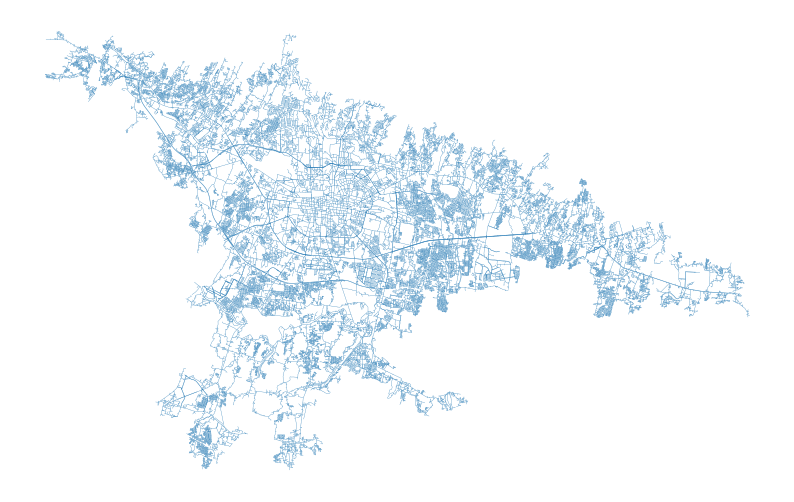

In [7]:
# Plot downloaded OSM roads

bandung_gdf.plot(figsize=(10, 10), linewidth=0.2).set_axis_off()

In [8]:
# Calculate continuity from the gdf

continuity = momepy.COINS(bandung_gdf, angle_threshold=135, flow_mode=False)

In [9]:
# Pull out stroke

bandung_stroke_gdf = continuity.stroke_gdf()

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Alpha: 3.286133692290621
xmin: 9.0
p-value: 0.035999578038191093
-----------------------
Log-likelihood ratio (R): 216.44892688541975
p-value for comparison: 1.350645718512768e-20


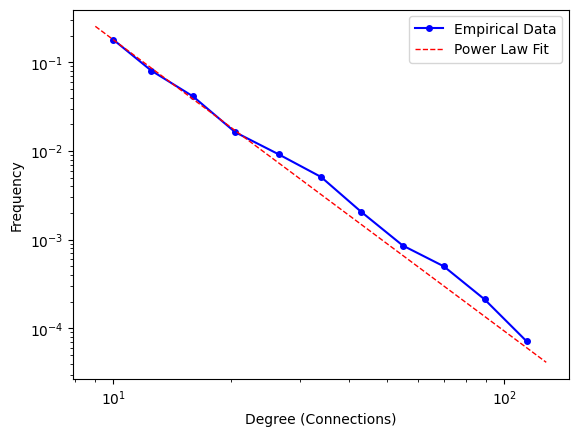

In [66]:
# Initialize the vertex-to-linestring mapping
vertex_to_linestring = defaultdict(list)

# Iterate over geometries and map vertices to LineStrings (handle MultiLineString)
for idx, geom in bandung_stroke_gdf.geometry.items():
    if isinstance(geom, LineString):  # Process single LineString
        for point in geom.coords:
            vertex_to_linestring[Point(point)].append(idx)
    elif isinstance(geom, MultiLineString):  # Process MultiLineString
        # For each LineString in MultiLineString
        for subline in geom.geoms:
            for point in subline.coords:
                vertex_to_linestring[Point(point)].append(idx)

# Initialize a dictionary to store the connection counts for each line
line_connections = defaultdict(int)

# Iterate over the geometries again to count connections
for idx, geom in bandung_stroke_gdf.geometry.items():
    if isinstance(geom, LineString):  # Process single LineString
        connections = []  # Use a list to count multiple connections
        for point in geom.coords:
            for connected_line in vertex_to_linestring[Point(point)]:
                if connected_line != idx:
                    connections.append(connected_line)  # Add connection to the list
        line_connections[idx] = len(connections)  # Store the total number of connections
    elif isinstance(geom, MultiLineString):  # Process MultiLineString
        # For each LineString in MultiLineString
        for subline in geom.geoms:
            connections = []  # Use a list to count multiple connections for each subline
            for point in subline.coords:
                for connected_line in vertex_to_linestring[Point(point)]:
                    if connected_line != idx:
                        connections.append(connected_line)  # Add connection to the list
            # Store the connection count for each subline (if necessary)
            # For now, we store the count for the entire MultiLineString
            line_connections[idx] = len(connections)


# Extract degree (number of connections) values
degree_values = list(line_connections.values())

# Count frequencies of degree values
degree_counts = Counter(degree_values)

# Extract x (degrees) and y (frequencies)
x = np.array(list(degree_counts.keys()))       # Unique degree values
y = np.array(list(degree_counts.values()))    # Frequency of each degree

# Fit the degree distribution to a power-law model
fit = powerlaw.Fit(degree_values)
print(f"Alpha: {fit.alpha}")
print(f"xmin: {fit.xmin}")

# Get alpha and xmin (scaling parameter and lower bound for the power-law fit)
alpha = fit.alpha
xmin = fit.xmin

# Get the p-value from the goodness-of-fit test
p_value = fit.power_law.KS()

print(f"p-value: {p_value}")
print("-----------------------")
# Compare the power-law fit with an alternative distribution (e.g., exponential)
R, p_alt = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio (R): {R}")
print(f"p-value for comparison: {p_alt}")

# Plot the data and the fitted power law
fig = fit.plot_pdf(marker='o', color='blue', markersize=4, label='Empirical Data')
fit.power_law.plot_pdf(ax=fig, color='red', linestyle='--', linewidth=1, label='Power Law Fit')

# Add legend and labels
plt.xlabel("Degree (Connections)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

HeadTailBreaks

    Interval       Count
------------------------
[  0.00,   2.86] | 24224
(  2.86,   5.73] |  8326
(  5.73,  10.76] |  2528
( 10.76,  19.74] |   670
( 19.74,  33.76] |   200
( 33.76,  52.14] |    59
( 52.14,  73.10] |    17
( 73.10,  87.79] |     8
( 87.79, 101.33] |     4
(101.33, 117.50] |     1
(117.50, 128.00] |     1


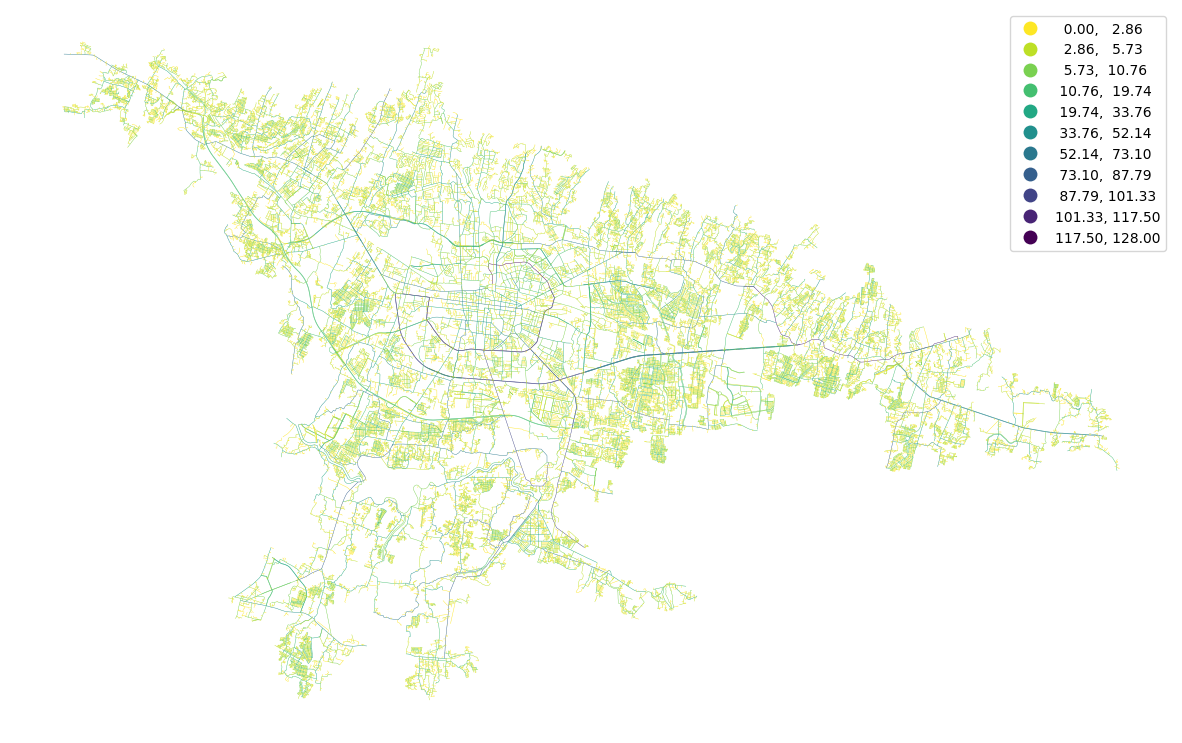

In [68]:
# Add connections to original gdf
bandung_stroke_gdf['n_connections'] = degree_values

# Calculate heavy tailed classification
classifier = mapclassify.HeadTailBreaks(degree_values)

# Show the classifier (lower and upper bounds plus count)
print(classifier)

# Plot natural streets
bandung_stroke_gdf.plot(
    figsize=(15, 15),
    cmap="viridis_r",
    column="n_connections", # uses number of connection per segment(individual segments are determined with COINS)
    legend=True,
    linewidth=0.3,
    scheme="headtailbreaks", # break n_connections by head/tails
).set_axis_off()

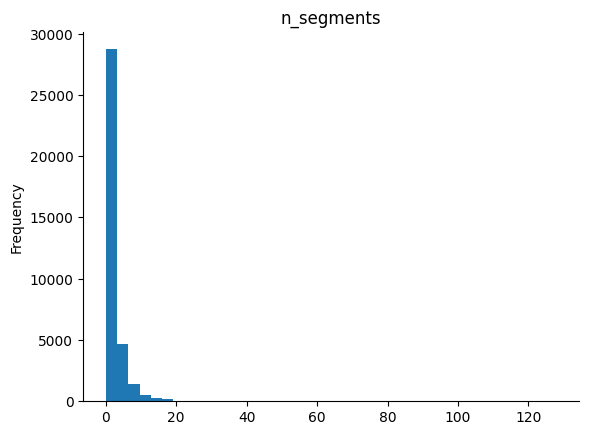

In [69]:
# Histogram for n_segments

from matplotlib import pyplot as plt
bandung_stroke_gdf['n_connections'].plot(kind='hist', bins=40, title='n_segments')
plt.gca().spines[['top', 'right',]].set_visible(False)